In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler


import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
len(available_segments)

46

In [5]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
#         rand = np.arange(171008)
#         np.random.shuffle(rand)
#         rand = rand[:150]
#         print(rand)
#         self.image_dir = list(unpickling(image_dir))[rand]
#         self.label_dir = list(unpickling(label_dir))[rand]
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [6]:
# torch.from_numpy()
rand = np.arange(171008)
np.random.shuffle(rand)
rand = rand[:150]

train_file_names = unpickling("/scratch/ark576/train_file_names")
train_label_names = unpickling("/scratch/ark576/train_label_names")
rand1 = np.arange(len(train_file_names))
np.random.shuffle(rand1)
rand1 = rand1[:1000]

val_file_names = unpickling("/scratch/ark576/val_file_names")
val_label_names = unpickling("/scratch/ark576/val_label_names")
rand2 = np.arange(len(val_file_names))
np.random.shuffle(rand2)
rand2 = rand2[:300]

test_file_names = unpickling("/scratch/ark576/test_file_names")
test_label_names = unpickling("/scratch/ark576/test_label_names")
rand3 = np.arange(len(test_file_names))
np.random.shuffle(rand3)
rand3 = rand3[:150]



In [7]:
# transformed_dataset = {'train': BrainImages("train_file_names","train_label_names", train_data= True, flipping=False),
#                        'validate': BrainImages("val_file_names","val_label_names"),
#                        'test': BrainImages("test_file_names","test_label_names")}
transformed_dataset = {'train': BrainImages(np.array(train_file_names)[rand1],np.array(train_label_names)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(val_file_names)[rand2],np.array(val_label_names)[rand2]),
                       'test': BrainImages(np.array(test_file_names)[rand3],np.array(test_label_names)[rand3])
                                               }



dataloader = {x: DataLoader(transformed_dataset[x], batch_size=18,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [8]:
#eg_path = '/scratch/ark576/data-reduced/996782/seperated_images/aseg_images/'

In [9]:
#eg_labels = os.listdir(eg_path)

In [10]:
#for i in range(len(eg_labels)):
#    eg_labels[i] = eg_path+eg_labels[i]

In [11]:
# eg_image_path = '/scratch/ark576/data-reduced/996782/seperated_images/t1_images/'
# eg_images = os.listdir(eg_image_path)
# for i in range(len(eg_images)):
#     eg_images[i] = eg_image_path+eg_images[i]

In [12]:
# transformed_dataset = {'train': BrainImages(np.array(eg_images),np.array(eg_labels), train_data= True, flipping=False),
#                        'validate': BrainImages(np.array(val_file_names)[rand2],np.array(val_label_names)[rand2]),
#                        'test': BrainImages(np.array(test_file_names)[rand3],np.array(test_label_names)[rand3])
#                                                }



# dataloader = {x: DataLoader(transformed_dataset[x], batch_size=15,
#                         shuffle=True, num_workers=0) for x in ['train']}
# data_sizes ={x: len(transformed_dataset[x]) for x in ['train']}

In [13]:
#label_dir = unpickling("/scratch/ark576/train_file_names")

In [12]:
#len(label_dir)

In [13]:
inputs = next(iter(dataloader['train']))

In [14]:
# def imshow(inp):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose(1,2,0)
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)

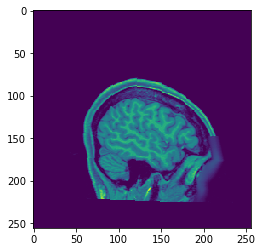

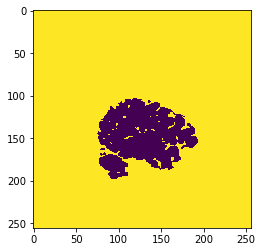

In [15]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [16]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [17]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [18]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,46, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [19]:
# def dice_loss(true,scores, epsilon = 1e-4):
#     preds = F.softmax(scores)
#     N, C, sh1, sh2 = true.size()
#     true = true.view(N, C, -1)
#     preds = preds.view(N, C, -1)
#     wts = torch.sum(true, dim = 2) + epsilon
# #     print(wts)
#     wts = 1/torch.pow(wts,2)
#     wts = torch.clamp(wts,0,0.1)
#     wts[wts == 0.1] = 0
#     wts = wts/Variable(torch.sum(wts,dim = 1).data.unsqueeze_(1))
#     print(wts)
#     prod = torch.sum(true*preds,dim = 2)
#     sum_tnp = torch.sum(true + preds, dim = 2)
#     num = torch.sum(wts * prod, dim = 1)
#     denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
#     loss = 1 - 2*(num/denom)
#     return torch.mean(loss)

In [20]:
voxel_count = pd.read_csv('/scratch/ark576/segment_counts.csv')

In [21]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [22]:
wts_num

array([  1.55181717e+07,   2.27132558e+05,   2.71765411e+05,
         6.20701527e+03,   1.97743037e+02,   1.40333845e+04,
         5.66883971e+04,   8.58384546e+03,   3.93285085e+03,
         5.57085894e+03,   1.45641330e+03,   7.34502246e+02,
         1.62191195e+03,   2.17487646e+04,   4.58532974e+03,
         1.62259928e+03,   1.07495148e+03,   5.93299191e+02,
         4.35026595e+03,   5.97843666e+01,   1.32094160e+03,
         2.34319566e+05,   2.76456036e+05,   5.75684007e+03,
         2.13104223e+02,   1.42446190e+04,   5.83411680e+04,
         7.62657951e+03,   3.99412040e+03,   5.70409075e+03,
         1.51298922e+03,   4.62344924e+03,   1.70840701e+03,
         6.55268643e+02,   4.41450494e+03,   6.94510332e+01,
         1.43331087e+03,   4.20664870e+00,   9.93678347e+02,
         9.23360288e+00,   2.37004492e+02,   9.80229111e+02,
         5.00247978e+02,   5.20355795e+02,   5.22881402e+02,
         9.22082659e+02])

In [23]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [50]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 1):
    preds = F.softmax(scores)
    N, C, sh1, sh2 = true.size()
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     print(wts)
    mean = 1/torch.pow(mean,p)
#     print(wts.size())
#     print(mean)
#     wts = torch.clamp(wts,0,0.1)
    wts[:,:] = mean[None].repeat(N,1)
#     wts[:,-1] = 0
#     wts[wts == 0.1] = 0
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    #print(wts)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [51]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss) 
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist

In [42]:
saved_model = Unet().cuda()

In [32]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 1e-4)

In [33]:
model, loss_hist = train_model(model, optimizer,dataloader,data_sizes,18,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 1.0080
----------
Epoch: 0, Phase: validate, epoch loss: 1.0200
----------
0
Epoch: 1, Phase: train, epoch loss: 1.0080
----------
Epoch: 1, Phase: validate, epoch loss: 1.0200
----------
1
Epoch: 2, Phase: train, epoch loss: 1.0080
----------
Epoch: 2, Phase: validate, epoch loss: 1.0200
----------
2
Epoch: 3, Phase: train, epoch loss: 1.0080
----------
Epoch: 3, Phase: validate, epoch loss: 1.0200
----------
3
Epoch: 4, Phase: train, epoch loss: 1.0080
----------
Epoch: 4, Phase: validate, epoch loss: 1.0200
----------
4
Epoch: 5, Phase: train, epoch loss: 1.0080
----------
Epoch: 5, Phase: validate, epoch loss: 1.0200
----------
5
Epoch: 6, Phase: train, epoch loss: 1.0080
----------
Epoch: 6, Phase: validate, epoch loss: 1.0200
----------
6
Epoch: 7, Phase: train, epoch loss: 1.0080
----------
Epoch: 7, Phase: validate, epoch loss: 1.0200
----------
7
Epoch: 8, Phase: train, epoch loss: 1.0079
----------
Epoch: 8, Phase: validate, epoch loss: 1.0

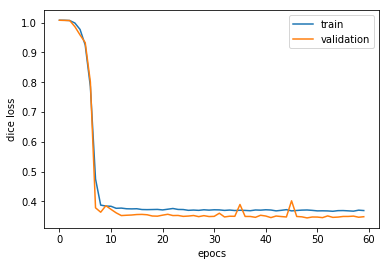

In [55]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [27]:
log_df = pd.read_csv("log_df.csv")
log_model_detail = pd.read_csv("log_model_detail.csv")
# log_df["job-model3-train-10000-54lr-15epoc"] = loss_hist["train"]
# log_df["job-model3-val-10000-54lr-15epoc"] = loss_hist["validate"]
# log_df.to_csv("log_df.csv",index=False)


In [56]:
# log_df = pd.DataFrame()
# log_df["train-model2-60ep-54lr"] = loss_hist["train"]

In [115]:
# log_df["val-model2-60epoc-54lr"] = loss_hist["validate"]


In [122]:
#log_model_detail = pd.DataFrame(columns=["model_name","n_epocs","lr","train_size","val_size","time_to_train"])

In [123]:
#log_model_detail.loc[0] = ["model2-60epoc-54lr",60,5e-4,1000,250,"187m 21s"]

In [125]:
#log_model_detail.loc[1] = ["job-model3-train-10000-54lr-15epoc",15,5e-4,10000,500,"unknown_yet"] 

In [127]:
#log_model_detail.to_csv("log_model_detail.csv",index=False)

In [38]:
log_model_detail

,model_name,n_epocs,lr,train_size,val_size,time_to_train
0,model2-60epoc-54lr,60,0.0005,1000,250,187m 21s
1,job-model3-train-10000-54lr-15epoc,60,0.0005,10000,500,1140 m


In [28]:
log_df

,train-model2-60ep-54lr,val-model2-60epoc-54lr,job-model3-train-10000-54lr-15epoc,job-model3-val-10000-54lr-15epoc
0,1.007970,1.007959,0.706104,0.382323
1,1.007850,1.007464,0.365590,0.379418
2,1.006987,1.006976,0.361220,0.363653
3,0.998581,0.986278,0.360624,0.360698
4,0.977035,0.958624,0.360189,0.361771
5,0.924728,0.932834,0.358533,0.361550
6,0.785197,0.800749,0.358795,0.360421
7,0.474804,0.378078,0.359170,0.360012
8,0.387180,0.363345,0.358171,0.359662
9,0.384012,0.385188,0.357640,0.360637


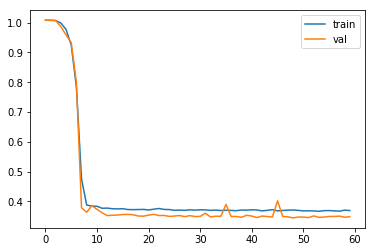

In [55]:
plt.plot(log_df["train-model2-60ep-54lr"],label="train")
plt.plot(log_df["val-model2-60epoc-54lr"],label="val")
plt.legend()
plt.show()

In [56]:
min(log_df["val-model2-60epoc-54lr"])

0.3441625964641571

In [82]:
#log_df.to_csv("log_df.csv",index=False)

In [60]:
# optimizer = optim.Adam(model.parameters(),lr = 1e-5)
# model, loss_hist = train_model(model, optimizer,dataloader,data_sizes,5,
#                                                                 num_epochs = 25, verbose = True)

In [43]:
# pickling(model,"model1-50ep-15lr")
torch.save(model,'model2-60epoc-54lr')

In [48]:
#torch.load("model2-60epoc-54lr")

In [52]:
saved_model = Unet().cuda()
saved_model = nn.DataParallel(saved_model)

In [57]:
saved_model = torch.load("model2-60epoc-54lr")

In [80]:
data = next(iter(dataloader["validate"]))

In [81]:
saved_model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = saved_model(x)



In [60]:
print(data['y'].size())
print(output.size())

torch.Size([18, 46, 256, 256])
torch.Size([18, 46, 256, 256])


In [61]:
def visualize(image, class_viz, title):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    masked = (p_maxim==class_viz).data.type(torch.cuda.FloatTensor)
    plt.title(title)
    plt.imshow(masked[:,:].cpu().numpy())

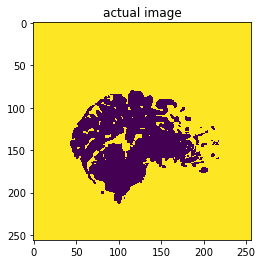

In [67]:
visualize(data['y'][1,:,:,:],0,"actual image")

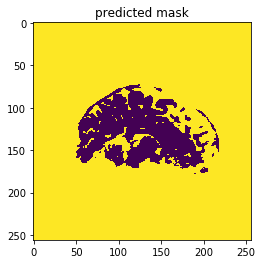

In [68]:
visualize(output[1,:,:,:],0,"predicted mask")

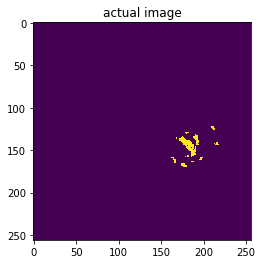

In [72]:
visualize(data['y'][1,:,:,:],2,"actual image")

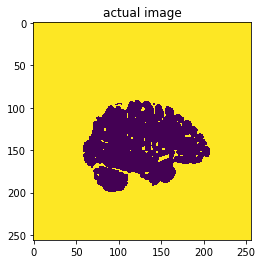

In [86]:
visualize(data['y'][3,:,:,:],0,"actual image")

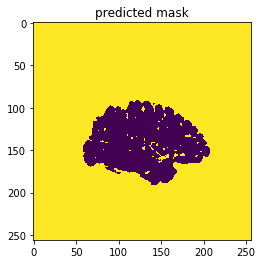

In [94]:
visualize(output[3,:,:,:],0,"predicted mask")

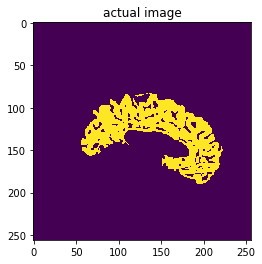

In [98]:
visualize(data['y'][4,:,:,:],2,"actual image")

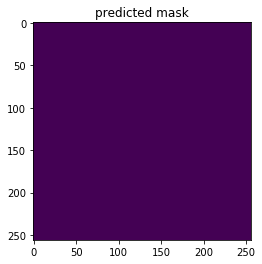

In [99]:
visualize(output[4,:,:,:],2,"predicted mask")

In [80]:
#visualize(data['y'][10,:,:,:],17)

In [81]:
#plt.imshow(output[10,0,:,:].data.cpu().numpy())